In [1]:
import psycopg2
import pickle
import time
import matplotlib.pyplot as plt

from net import TwitteRNN
from multiprocessing import Pool
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
connection = psycopg2.connect('host=52.178.108.157 dbname=postgres user=outsider password=IS3xsTfRZb0B')
cursor = connection.cursor()

In [3]:
model = TwitteRNN(vocab_size=100000, max_seq_len=1000)
model.create_model()
model.load_model(weights_path="./model_checkpoints/weights-improvement-02-0.823.hdf5",
                 dict_filename="./model_dict.pickle")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 16)          1600000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 32)          1568      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 500, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,654,869
Trainable params: 1,654,869
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cursor.execute("SELECT id, body, origin_id FROM posts WHERE origin_id in (19, 42);")
post_id_body = cursor.fetchall()

In [18]:
text = "Fiat"
model.predict(text)

0.80128807

In [21]:
text = "Hey, I just checked it out and I’m excited. I’m going to try using this for a little while and see how it goes, but I’d love to give you guys some feedback."
model.predict(text)

0.79605836

In [32]:
model.predict("")

-1

In [33]:
text_split = text.split(" ")
for i in range(1, len(text_split)):
    current_text = " ".join(text_split[0:i])
    print(current_text)
    print(model.predict(current_text))

Literally
0.389719
Literally ur
0.647782
Literally ur facebook
0.605595
Literally ur facebook message
0.872038
Literally ur facebook message app
0.632413
Literally ur facebook message app is
0.518565
Literally ur facebook message app is useless,
0.490876
Literally ur facebook message app is useless, you
0.683599
Literally ur facebook message app is useless, you only
0.387272
Literally ur facebook message app is useless, you only want
0.346327
Literally ur facebook message app is useless, you only want it
0.274147
Literally ur facebook message app is useless, you only want it to
0.309235
Literally ur facebook message app is useless, you only want it to increase
0.255083
Literally ur facebook message app is useless, you only want it to increase profit.
0.474035
Literally ur facebook message app is useless, you only want it to increase profit. Please
0.462664
Literally ur facebook message app is useless, you only want it to increase profit. Please fix
0.542001
Literally ur facebook messag

In [77]:
text = "This is a really interesting paper, but the conclusions section was a bit disappointing."
words = text.split(" ")
sentiments = []
input_words = ""
temp_dict = []
for i in range(len(words)):
    input_words += words[i]
    input_words += " "
    sentiments.append(model.predict(input_words))
    temp_dict.append((words[i], model.predict(input_words)))
temp_dict

[('This', 0.51497263),
 ('is', 0.5745737),
 ('a', 0.52914882),
 ('really', 0.57332587),
 ('interesting', 0.93083155),
 ('paper,', 0.72515982),
 ('but', 0.59494323),
 ('the', 0.62939608),
 ('conclusions', 0.96356601),
 ('section', 0.83229619),
 ('was', 0.92375183),
 ('a', 0.88709682),
 ('bit', 0.93826872),
 ('disappointing.', 0.42111591)]

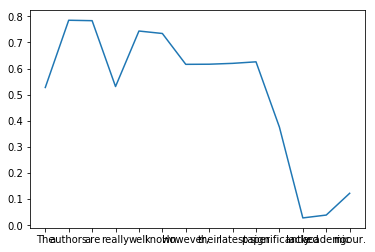

In [88]:
sent = []
words = []
for elem in temp_dict:
    sent.append(elem[1])
    words.append(elem[0])

plt.xticks(range(len(words)), words)
plt.plot(range(len(words)), sent)
plt.show()


In [89]:
text = "The authors are well known. However, this paper significantly lacked academic rigour."
words = text.split(" ")
sentiments = []
input_words = ""
temp_dict = []
for i in range(len(words)):
    input_words += words[i]
    input_words += " "
    sentiments.append(model.predict(input_words))
    temp_dict.append((words[i], model.predict(input_words)))
temp_dict

[('The', 0.52735597),
 ('authors', 0.78489256),
 ('are', 0.78321391),
 ('well', 0.80364668),
 ('known.', 0.8345353),
 ('However,', 0.67787796),
 ('this', 0.59851164),
 ('paper', 0.26116103),
 ('significantly', 0.20735058),
 ('lacked', 0.0071025053),
 ('academic', 0.028599752),
 ('rigour.', 0.10216416)]

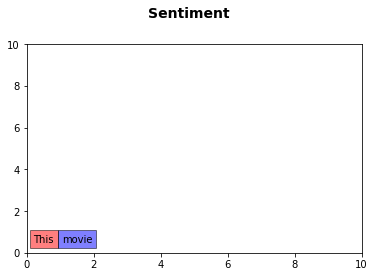

In [61]:
fig = plt.figure()
fig.suptitle("Sentiment", fontsize=14, fontweight="bold")

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)

ax.text(0.2, 0.5, "This", bbox={"facecolor":"red", "alpha":0.5})
ax.text(1.05, 0.5, "movie", bbox={"facecolor":"blue", "alpha":0.5})
ax.text(1.2, 0.5, "is", bbox={"facecolor":})

ax.axis([0, 10, 0, 10])

plt.show()

In [35]:
# Get sentiments for post ids
bar = tqdm(total=len(post_id_body))
post_id_sentiment = []
for post in post_id_body:
    post_id_sentiment.append((post[0], model.predict(post[1]), post[2]))
    bar.update()

NameError: name 'post_id_body' is not defined

In [7]:
with open("post_id_sentiment_reddit.pickle", "rb") as f:
    post_id_sentiment = pickle.load(f)

In [6]:
#with open("post_id_sentiment.pickle", "rb") as f:
#    post_id_sentiment = pickle.load(f)

In [9]:
cursor.execute("SELECT post_id FROM posts_score;")
post_ids = cursor.fetchall()
for post in post_id_body:
    post_ids.append(post[0])

In [15]:
# INSERT or UPDATE if exists
bar = tqdm(total=len(post_id_sentiment))

batch = ""

i = 1

for pair in post_id_sentiment:
    
    post_id = int(pair[0])
    sentiment = float(pair[1])
    origin_id = int(pair[2])
        
    if i%10000 == 0:
        cursor = connection.cursor()
        cursor.execute(batch)
        connection.commit()
        cursor.close()
        batch = ""
    else:
        if post_id in post_ids:
            batch += "UPDATE posts_score SET sentiment = %s WHERE post_id = %s; " % (sentiment, post_id)
        else:
            batch += "INSERT INTO posts_score (post_id, sentiment, origin_id) VALUES (%s, %s, %s); " % (post_id, sentiment, origin_id)

    i += 1
    bar.update()

cursor = connection.cursor()
cursor.execute(batch)
connection.commit()
cursor.close()


100%|██████████| 108995/108995 [1:15:35<00:00, 24.27it/s]  

In [16]:
connection.close()